# Ridge regression

 A large coeficient on one variable x_i*y_j can be canceled by a large negative coeficient on another. By
 imposing a constraint on the size of the variables we can punish this behaviour! 

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ridge regression with Cross Validation

In [254]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import Ridge as Ridge_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import Ridge

x = np.linspace(0, 1, 50) # flere punkter, mindre mse? 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 16
k_folds = 7
lambda_ridge = 0.1
MSE_test_list = [] 
MSE_train_list = []
MSE_skl_list = []

z = Fr(x, y)
noise = np.var(z)*np.random.normal(size=z.shape)
z += noise*1

#noise = #np.random.randn(x.shape[0], x.shape[1])
#z = Fr(x, y) + noise*0.18 #multiply with degree of noice. 1*var_Fr = 0.18
    
x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

# Cross validation:
# shuffle data:
order = np.arange(x_cent.shape[0]) #number of data points
np.random.shuffle(order)
x_cent_ = x_cent[order].ravel().reshape(-1,1)
y_cent_ = y_cent[order].ravel().reshape(-1,1)
z_cent_ = z_cent[order].ravel().reshape(-1,1)
xyz_shuffle = np.hstack([x_cent_, y_cent_, z_cent_])
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for k in tqdm.tqdm(range(k_folds)): 
    MSE_test = []
    MSE_train = []
    MSE_skl = []
    
    # extract folds
    xyz_test = xyz_folds[k]
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold

    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(
            degree=poly_deg), Ridge_skl(alpha=lambda_ridge, fit_intercept=True))
        model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge)
        
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) #tester modellen på test
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel())) # tester på fit
        
        #sklearn:
        z_pred = model_skl.fit(xy_train, z_train.reshape(-1, 1)).predict(xy_test)
        MSE_skl.append(np.mean((z_pred.ravel() - z_test.ravel())**2)) # tester modellen mot
        
    MSE_test_list.append(MSE_test) 
    MSE_train_list.append(MSE_train)
    MSE_skl_list.append(MSE_skl)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)
MSE_skl_list = np.array(MSE_skl_list)

#study average values
test_pol_avrg = np.mean(MSE_test_list, axis=0) 
train_pol_avrg = np.mean(MSE_train_list, axis=0)
test_skl_avrg = np.mean(MSE_skl_list, axis=0)

100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


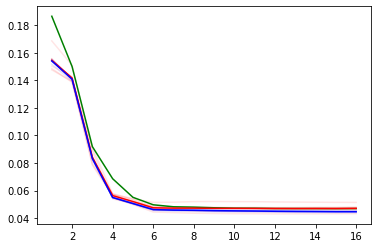

In [255]:
for i in range(len(MSE_test_list)):
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 
    #plt.plot(range(1, len(MSE_test)+1), MSE_skl_list[i], 'r', alpha=0.1)

plt.plot(range(1, len(MSE_test)+1), test_skl_avrg, 'g')
plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_train)+1), train_pol_avrg, 'b')
#plt.plot(range(1, len(variance_avrg)+1), variance_avrg, 'g')

#plt.ylim(0.95, 1.1)
plt.show()
# Observasjonar: 
# I Plottet under: Trekker ulike samples fra datasettet (med tilbakelegging) og predikerer optimal fit for ulike 
# polynomer med grad p. 

# I eksempelet over brukte eg ulike seed-verdier for å lage ulike utfall av støy. 
# I dette eksempelet viser me at det er mulig å modellere usikkerheit med  

## Ridge Regression with bootstrap

In [259]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import Ridge as Ridge_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import Ridge

x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 18
n_bootstraps = 70
lambda_ridge = 0.00001
MSE_test_list = [] 
MSE_train_list = []
MSE_skl_list = [] # test..
predict_train_list = []
betas_list = []
predict_train_skl_list = []

z = Fr(x, y)
noise = np.var(z)*np.random.normal(size=z.shape)
z += noise*1

x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                        z_cent, test_size=0.5)

# 1 bootstrap som er lik train skal oppføre seg som i k-fold? 

for n in tqdm.tqdm(range(n_bootstraps)): 
    #print("Bootstrap number: " + str(n+1) + '/' + str(n_bootstraps))
    MSE_test = []
    MSE_train = []
    MSE_skl = []
    predict_train = []
    predict_train_skl = []
    beta_poly = np.zeros([poly, (poly + 1)**2])
    
    #draw n samples from train set
    n = z_cent_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_cent_train[samples_nr, :] # sampling train data
    z_samp = z_cent_train[samples_nr, :]
        
    # feilen øker for store polynom, har det med at eg sampler normalfordelt? 
    
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit own model
        model = Ridge(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg, lambda_ridge)
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test)) 
        MSE_train.append(model.MSE(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel())) # orig model.
        beta_poly[poly_deg-1, 0: (poly_deg+1)**2] = np.array(model.beta_Ridge.ravel()) # for numpy math later
        beta_poly[poly_deg-1, (poly_deg+1)**2: -1] = np.nan
        predict_train.append(model.predict(xy_samp[:, 0], xy_samp[:, 1]).ravel())# predicted model
        
        #SKlearn
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Ridge_skl(
            alpha=lambda_ridge, fit_intercept=True))
        z_pred = model_skl.fit(xy_samp, z_samp.reshape(-1, 1)).predict(xy_cent_test)
        MSE_skl.append(np.mean((z_pred.ravel() - z_cent_test.ravel())**2)) 
        
    # store all values for averaging
    MSE_test_list.append(MSE_test) 
    MSE_train_list.append(MSE_train)
    MSE_skl_list.append(MSE_skl)
    predict_train_list.append(predict_train)
    betas_list.append(beta_poly) 
    predict_train_skl_list.append(predict_train_skl)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)
MSE_skl_list = np.array(MSE_skl_list)
predict_train_list = np.array(predict_train_list)
predict_train_skl_list = np.array(predict_train_skl_list)
betas_list = np.array(betas_list, dtype=object)

#study average values
test_pol_avrg = np.mean(MSE_test_list, axis=0) 
train_pol_avrg = np.mean(MSE_train_list, axis=0)
test_skl_avrg = np.mean(MSE_skl_list, axis=0)
#predict_train_var = np.mean(np.var(predict_train_list, axis=0), axis=1) # mean( var( bootstrap attempts ))
mean_betas = np.mean(betas_list, axis=0) 
var_betas = np.var(betas_list, axis=0)

#predict_train_var_skl = np.mean(np.var(predict_train_skl_list, axis=0), axis=1) # mean( var( bootstrap attempts ))

100%|██████████| 70/70 [00:58<00:00,  1.19it/s]


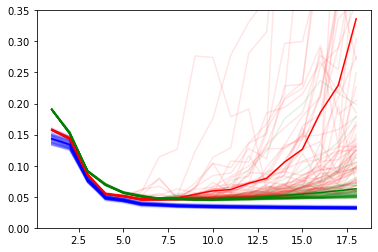

In [260]:
for i in range(len(MSE_test_list)):
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_skl_list[i], 'g', alpha=0.1)

plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_train)+1), train_pol_avrg, 'b')
plt.plot(range(1, len(MSE_test)+1), test_skl_avrg, 'g')

#plt.plot(range(1, len(variance_avrg)+1), variance_avrg, 'g')

plt.ylim(0, 0.35)
plt.show()
# Observajsoner: Standard scaler gjer at ridge ikkje fungerer! Det er ikkje sikkert kvifor. Ved å skalere manuelt 
# går det bra.. 

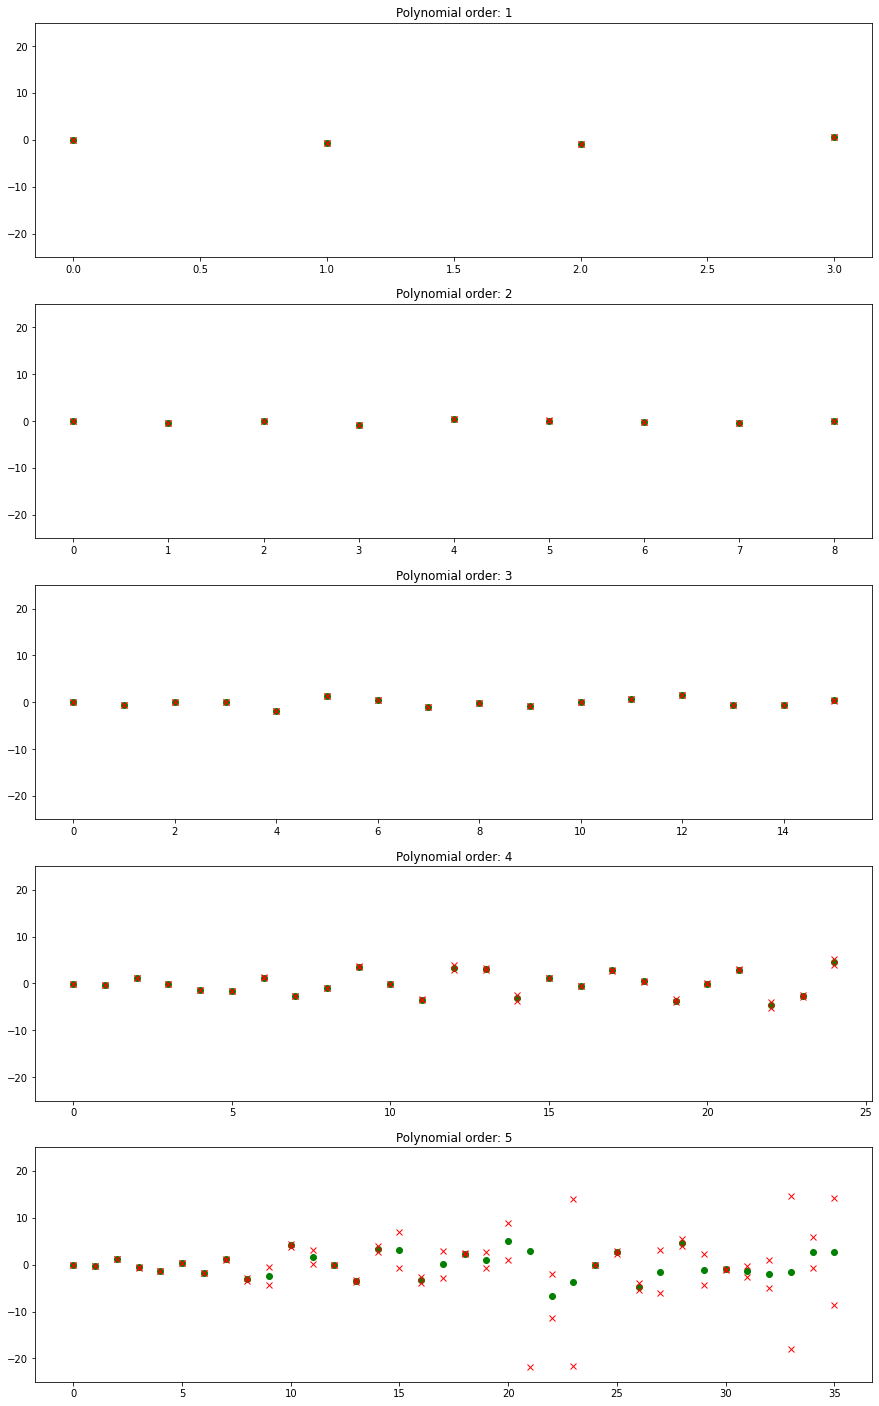

In [261]:
import matplotlib.pyplot as plt
n_polynom = 5 # plot polynoms up to n_polynom order
sigma = 2 # plot two sigma uncertainty
fig, axs = plt.subplots(n_polynom, 1, figsize=(15, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

sigma = 1
for polynom_nr in range(n_polynom):
    for beta_nr_i in range((polynom_nr+2)**2): # extracts first beta values! 
        axs[polynom_nr].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] - sigma*var_betas[
            polynom_nr][beta_nr_i], 'rx') 
        axs[polynom_nr].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] + sigma*var_betas[
            polynom_nr][beta_nr_i], 'rx') 

    axs[polynom_nr].set_title('Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr].set_ylim([-25, 25])
plt.show()

### Observasjoner: 
- Ridge med lav lambda gir tilnærma samme beta-verdier som den analytiske formelen for beta fra oppgave 2. Det ser også ut som at lav lambda gir en MSE_test som likner på den fra oppgave 2.  (lambda = 0.00000001)
- SklLearn gir for lave lambda ein mindre "eksplosiv" løysing i MSE enn min versjon av ridge. (lambda = 0.00000001)
- Dersom eg sett lambda høg nok dempes MSE_train som forventa. Høgare lambda gir MSE i optimum litt dårligare. Høgare lambda fører også til at beta veriane samler seg rundt 0 OG får ei mindre varians fra bootstrap samplinga!
- Dess fleire gonger eg kjører bootstrap samplinga dess meir liknar spredningen og variansen i beta på resultatet frå oppgaåve 1. 
- Ide: Lag eit plot der eg øker lambda og studerer korleis beta innsnevres, beta-innsnevering skal og følge ein lov.... Nevn denne dersom eg får god tid på oppgava:) 